### This is to study the relationship between phase in oscilation and performance


先经过100ms的pre-stimulaiton时间来让震荡稳定下来  
然后根据希尔伯特变换找到100ms后的第一个相位最低点的位置（-pi）  
从这个位置开始刺激10ms+测试  
全程200ms  

In [24]:
# import necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.signal import hilbert

from functions import Draw_Output, Draw_Conductance, Draw_RasterPlot, Draw_Voltage, Draw_Projection, show_mn, show_conn
from functions import  save_model, load_config_yaml
from functions import Generate_Vectors, Generate_RandomMatrix
from lowranksnn import LowRankSNN
plt.rcParams.update({'font.size': 30})  


In [25]:
# Read the configuration file
# config = load_config_yaml('config_test_phase_sensitivity.yaml')
# config = load_config_yaml('confi_gamma_os_bias_only.yaml')
config = load_config_yaml('config_test.yaml')

N_E = config['N_E']
N_I = config['N_I']
N = N_E + N_I
P_EE = config['P_EE']
P_EI = config['P_EI']
P_IE = config['P_IE']
P_II = config['P_II']
factor_mn = config['factor_mn'] # 组合成conn时乘在lowrank matrix上的常數
RS = config['RandomStrength'] # 组合成conn时乘在random matrix上的常數

taud_E = config['taud_E']
taud_I = config['taud_I']

eta_E = config['eta_E']
eta_I = config['eta_I']
delta_E = config['delta_E']
delta_I = config['delta_I']

mu = config['mu']
si = config['sigma']

si_rand = config['sigma_rand']
dt = config['dt'] #(ms/step)
T_pre = config['T_pre'] # length of time before sti (ms)
T_sti = config['T_sti'] # length of time for sti (ms)
T_after = config['T_after'] # length of time after sti (ms)
T = T_pre+T_sti+T_after # length of Period time (ms): 30ms

IS = config['InputStrength'] #Input Strength (maybe chage to norm in the future)

color_Go = config['color_Go']
color_Nogo = config['color_Nogo']

num_phase = config['num_phase']
trails = config['trails']


In [26]:
# Initialiazation
LRSNN = LowRankSNN(N_E=N_E,N_I=N_I,taud_E=taud_E,taud_I=taud_I,RS=RS)
# Go_NoGo Task
# Prepare the Low Rank Connectivity (Rank = 1), Stimuli and Readout Vector
m, n, Sti_nogo = Generate_Vectors(N, mu, si)
m[N_E:] = 0
n[N_E:] = 0
Sti_nogo[N_E:] = 0
Sti_go = n.clone()
W_out = m.clone()
W_rank1 = factor_mn*torch.ger(m.squeeze(), n.squeeze())
conn_rand = Generate_RandomMatrix(N_E, N_I, P_EE, P_EI, P_IE, P_II, W_rank1, sigma = si_rand)


In [27]:
# Assemble the Network
LRSNN.add_lowrank(W_rank1, W_out)
LRSNN.add_random(conn_rand)
# # count the number of values outside the range of 0 and 1
# print('Number of values outside the range of 0 and 1: ', torch.sum(LRSNN.conn>1)+torch.sum(LRSNN.conn<0))
# # ratio of values outside the range of 0 and 1 to the total number of values
# print('Ratio of values outside the range of 0 and 1 to the total number of values: ', (torch.sum(LRSNN.conn>1)+torch.sum(LRSNN.conn<0))/(N_E+N_I)**2)
LRSNN.conn[LRSNN.conn>1] = 1
LRSNN.conn[LRSNN.conn<0] = 0

Low Rank connection and readout vector have been added.
Random connection has been added.


In [28]:
# 1st simulation: get the first zero phase time after 100 ms (use hilbert transform)

T = T_pre+T_sti+T_after # length of Period time (ms）

Input_go = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt))) #size:(N,time)
Input_go[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_go
Input_nogo = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt)))
Input_nogo[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_nogo
#

# bias current
bias = torch.zeros_like(Input_go)
bias[:N_E,:] = (eta_E+delta_E*torch.tan(torch.tensor(np.pi*(np.arange(1,N_E+1)/(N_E+1)-1/2)))).unsqueeze(1)
bias[N_E:,:] = (eta_I+delta_I*torch.tan(torch.tensor(np.pi*(np.arange(1,N_I+1)/(N_I+1)-1/2)))).unsqueeze(1)

#将模型及相应属性移动到GPU
device = torch.device('cuda:0')
LRSNN = LRSNN.to(device)
Input_go = Input_go.to(device)
Input_nogo = Input_nogo.to(device)
bias = bias.to(device)

# Start Simulation
# Out_go, V_go, g_go, I_syn_go, spk_step_go, spk_ind_go = LRSNN(dt,bias)
# Out_nogo, V_nogo, g_nogo, I_syn_nogo, spk_step_nogo, spk_ind_nogo = LRSNN(dt,Input_nogo+bias)
_, _, g_ref, _, _, _ = LRSNN(dt,bias)

g_ref_EE = g_ref[1]
g_ref_II = g_ref[-1]

# do hilbert transform to get the phase of the conductance
g_ref_EE = g_ref_EE.cpu().detach().numpy()
g_ref_II = g_ref_II.cpu().detach().numpy()


Low-rank connectivity is added to all the connections


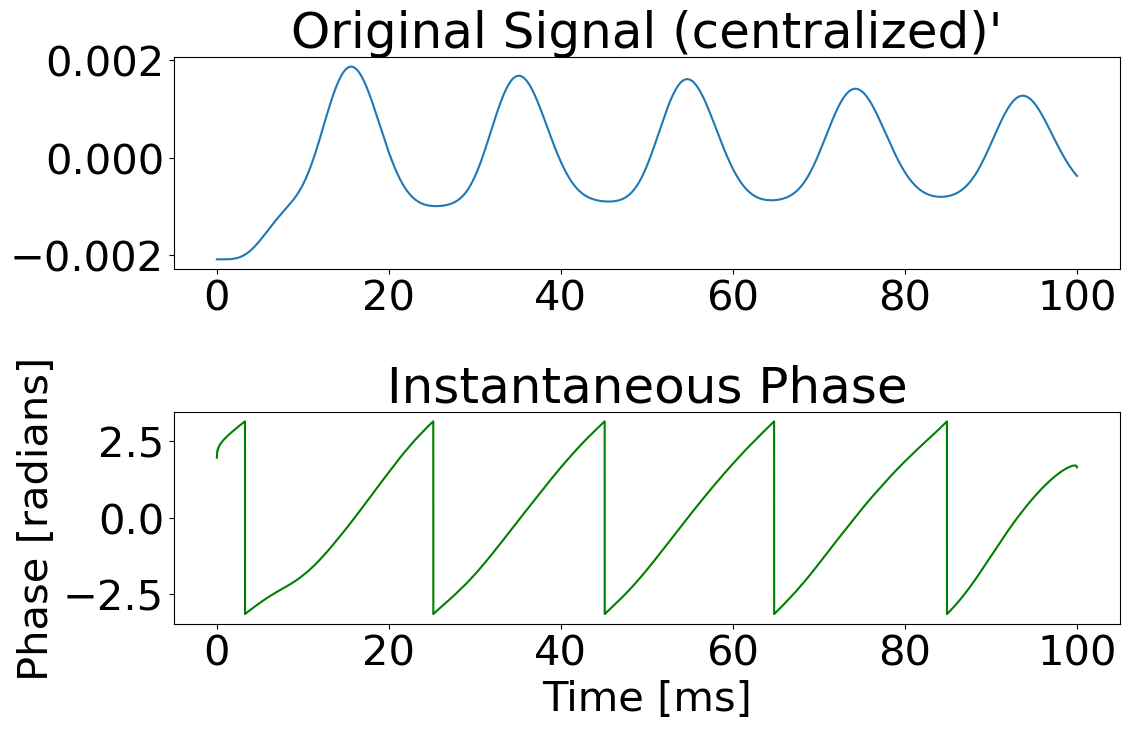

In [29]:

# do hilbert transform to get the phase of the conductance
signal = np.mean(g_ref_II, axis=0)[int(T_pre/dt):]

# filter out the high frequency noise in the signal
from scipy.signal import butter, lfilter
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y
signal = butter_lowpass_filter(signal, 100, 1000/dt, order=5) # cutoff frequency higher than 100 Hz

# centralize the signal
signal = signal - np.mean(signal)
analytic_signal = hilbert(signal)
amplitude_envelope = np.abs(analytic_signal)  # 振幅包络
instantaneous_phase = np.angle(analytic_signal)  # 相位信息
# 绘制波形及其相位信息
plt.figure(figsize=(12, 8))
t = np.array(range(len(signal)))*dt
# 原始信号
plt.subplot(2, 1, 1)
# plt.figure(figsize=(12, 8))
plt.plot(t, signal)
plt.title("Original Signal (centralized)'")
# plt.xlabel("Time [ms]")
# plt.ylabel("Amplitude")
# plt.legend()

# 振幅包络
# plt.subplot(3, 1, 2)
# plt.figure(figsize=(12, 8))
# plt.plot(t, amplitude_envelope, color='orange')
# plt.title("Amplitude Envelope (Magnitude of Analytic Signal)")
# plt.xlabel("Time [ms]")
# plt.ylabel("Amplitude")
# plt.legend()

# 相位信息
plt.subplot(2, 1, 2)
# plt.figure(figsize=(12, 8))
plt.plot(t, instantaneous_phase, color='green')
plt.title("Instantaneous Phase")
plt.xlabel("Time [ms]")
plt.ylabel("Phase [radians]")
# plt.legend()

plt.tight_layout()
plt.show()


In [30]:
# find out the first minimum phase
# take phase_start as -pi, and phase_end as pi
flag = 1
for i in range(len(instantaneous_phase)):
    if flag == 1 and instantaneous_phase[i]-instantaneous_phase[i+1]>np.pi:
        phase_start = instantaneous_phase[i+1]
        phase_start_ind = i+1
        flag = 0
        continue
    if flag == 0 and instantaneous_phase[i]-instantaneous_phase[i+1]>np.pi:
        phase_end = instantaneous_phase[i]
        phase_end_ind = i
        break

phases_eff = np.linspace(phase_start, phase_end, num_phase)

def nearest_phase_ind(arr, phase_target):
    return np.argmin(np.abs(arr-phase_target))

phases_eff_ind = phase_start_ind + np.array([nearest_phase_ind(instantaneous_phase[phase_start_ind:phase_end_ind+1],phase_target) for phase_target in phases_eff])
phases_eff = instantaneous_phase[phases_eff_ind]

# phases_eff_ind += int(T_pre/dt)
phases_eff_times = phases_eff_ind*dt # the time of the effective phases after T_pre (ms)


In [31]:
#simulation: get the reaction time for different phases

#store the reaction time for different phases
reaction_times = []

for T_phase in phases_eff_times:
    T_pre += T_phase
    T = T_pre+T_sti+T_after # length of Period time (ms）

    Input_go = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt))) #size:(N,time)
    Input_go[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_go
    Input_nogo = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt)))
    Input_nogo[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_nogo

    # bias current
    bias = torch.zeros_like(Input_go)
    bias[:N_E,:] = (eta_E+delta_E*torch.tan(torch.tensor(np.pi*(np.arange(1,N_E+1)/(N_E+1)-1/2)))).unsqueeze(1)
    bias[N_E:,:] = (eta_I+delta_I*torch.tan(torch.tensor(np.pi*(np.arange(1,N_I+1)/(N_I+1)-1/2)))).unsqueeze(1)
 
    #将模型及相应属性移动到GPU
    device = torch.device('cuda:0')
    LRSNN = LRSNN.to(device)
    Input_go = Input_go.to(device)
    Input_nogo = Input_nogo.to(device)
    bias = bias.to(device)

    # Start Simulation
    Out_go, V_go, g_go, I_syn_go, spk_step_go, spk_ind_go = LRSNN(dt,Input_go+bias)
    Out_nogo, V_nogo, g_nogo, I_syn_nogo, spk_step_nogo, spk_ind_nogo = LRSNN(dt,Input_nogo+bias)

    g_go_EE = g_go[1]
    g_nogo_EE = g_nogo[1]

    # define the reaction time as performance
    # reaction time: 从施加刺激开始到输出不为0的时间（或者到go输出大于nogo输出的时间）
    # calculate the time when the output of go exceed the output of nogo
    difference = Out_go - Out_nogo
    exceed_time = torch.nonzero(difference.squeeze()>0)[0].item()*dt
    reaction_time = exceed_time-T_pre
    reaction_times.append(reaction_time)
    print('Phase: ', phases_eff[phases_eff_times==T_phase])
    print('Reaction Time: ', reaction_time, 'ms')
    # prop = torch.max(Out_go)/torch.max(Out_nogo)
    # print('Performance: ', prop.item())
    T_pre -= T_phase


Low-rank connectivity is added to all the connections
Low-rank connectivity is added to all the connections
Phase:  [-3.14025546]
Reaction Time:  10.134999999999991 ms
Low-rank connectivity is added to all the connections
Low-rank connectivity is added to all the connections
Phase:  [-1.56985014]
Reaction Time:  9.450000000000003 ms
Low-rank connectivity is added to all the connections
Low-rank connectivity is added to all the connections
Phase:  [0.000904]
Reaction Time:  10.125 ms
Low-rank connectivity is added to all the connections
Low-rank connectivity is added to all the connections
Phase:  [1.57100716]
Reaction Time:  10.129999999999995 ms
Low-rank connectivity is added to all the connections
Low-rank connectivity is added to all the connections
Phase:  [3.14152295]
Reaction Time:  10.140000000000015 ms


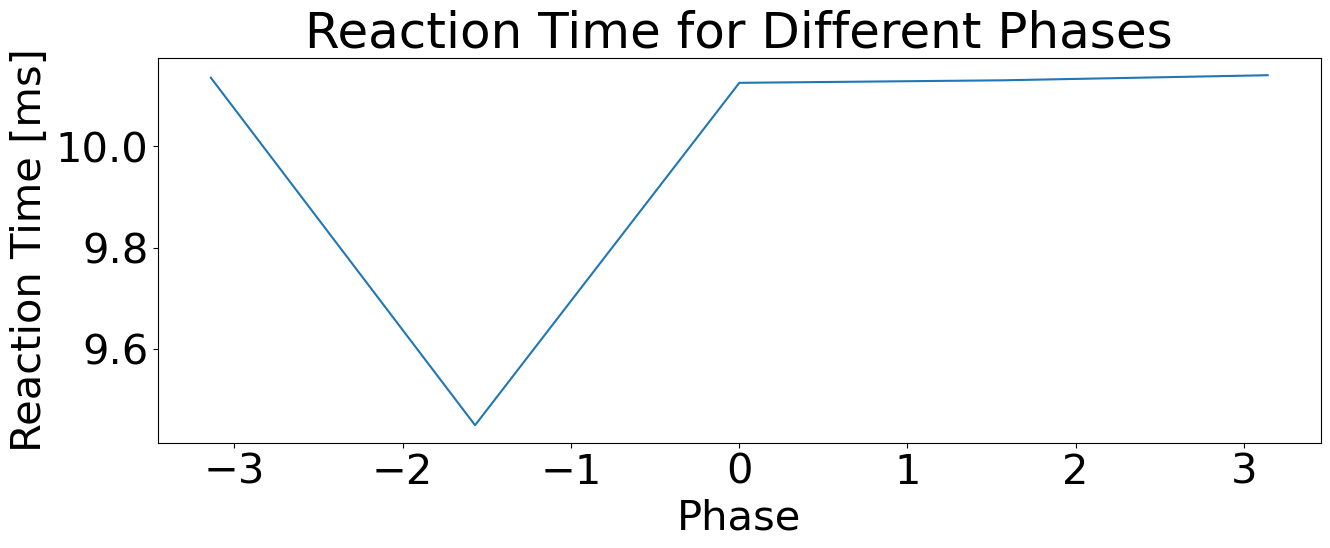

In [33]:
# phases list (from -pi to pi)
phases = 2*np.pi*np.linspace(0, 1, num_phase)-np.pi

# plot the reaction time for different phases
plt.figure(figsize=(15, 5))
plt.plot(phases_eff, reaction_times)
plt.xlabel('Phase')
plt.ylabel('Reaction Time [ms]')
plt.title('Reaction Time for Different Phases')
plt.show()


In [44]:
import csv
import datetime
now = datetime.datetime.now()
filename = './data_phase_to_reaction_times/reaction_times_'+now.strftime('%y%m%d%H%M%S')+'.csv'
with open(filename, mode='w') as file:
    writer = csv.writer(file)
    for i in range(len(phases_eff)):
        writer.writerow([phases_eff[i], reaction_times[i]])

reaction_times_241108092428.csv


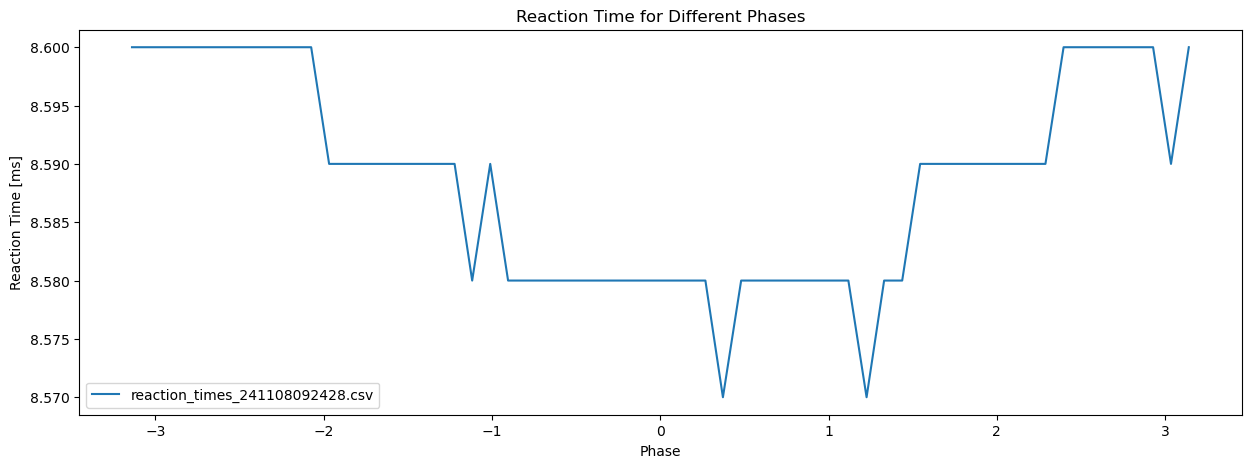

reaction_times_241108070650.csv


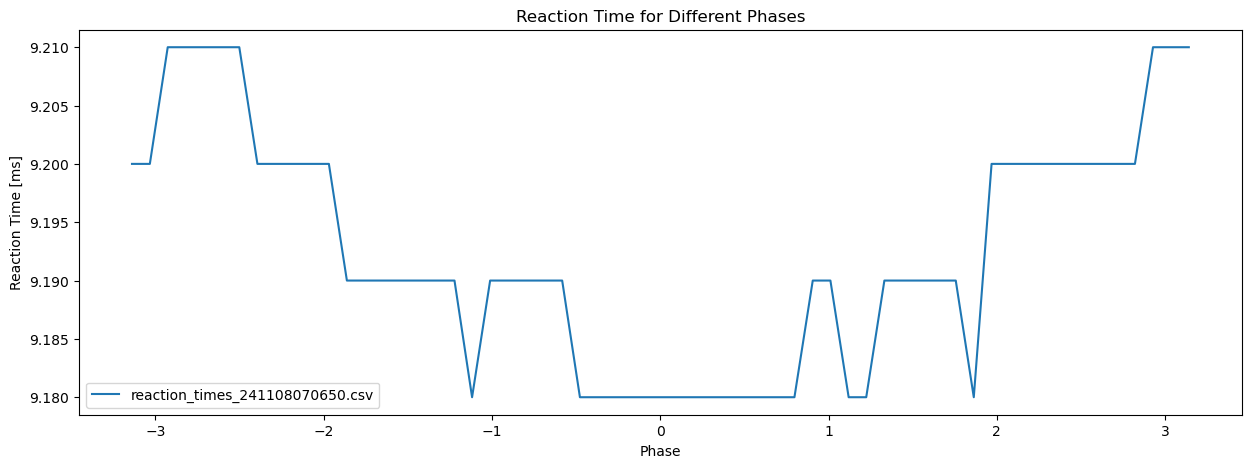

reaction_times_241108023314.csv


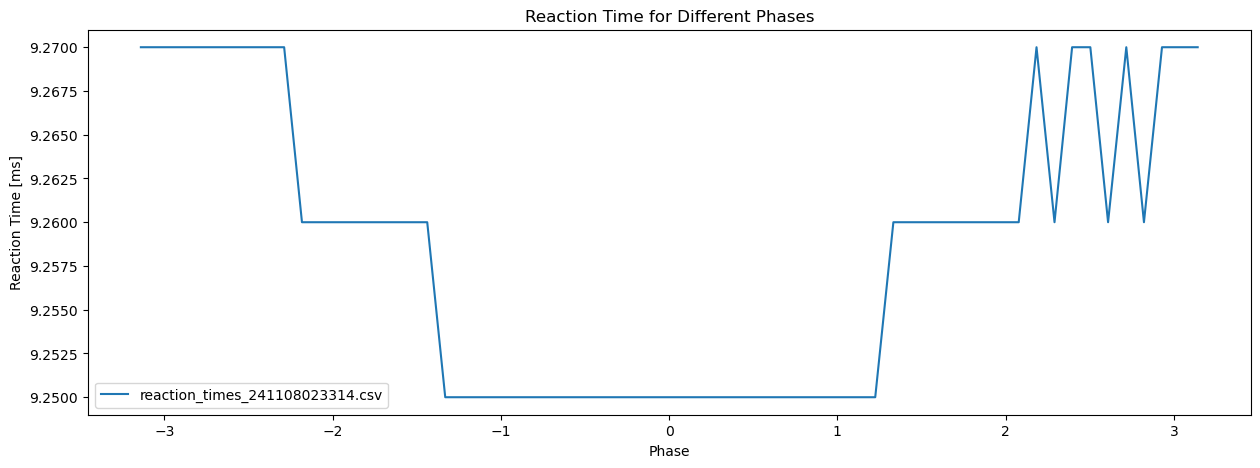

reaction_times_241108045023.csv


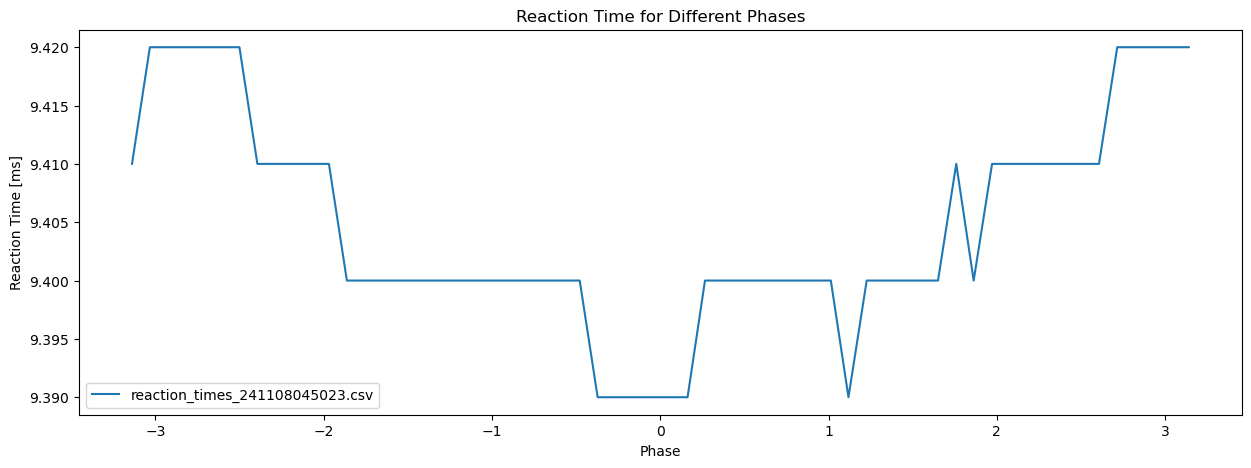

reaction_times_241108001631.csv


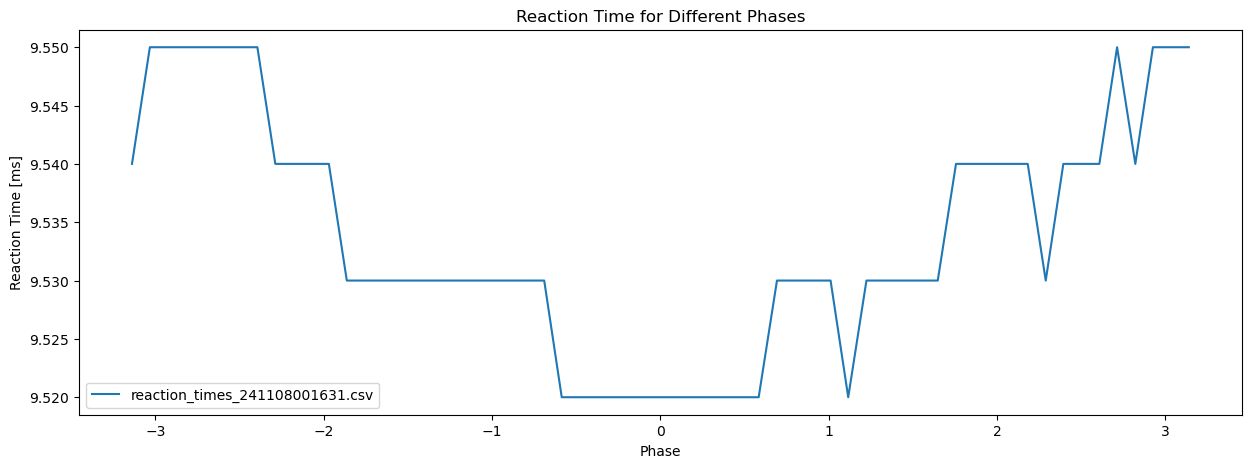

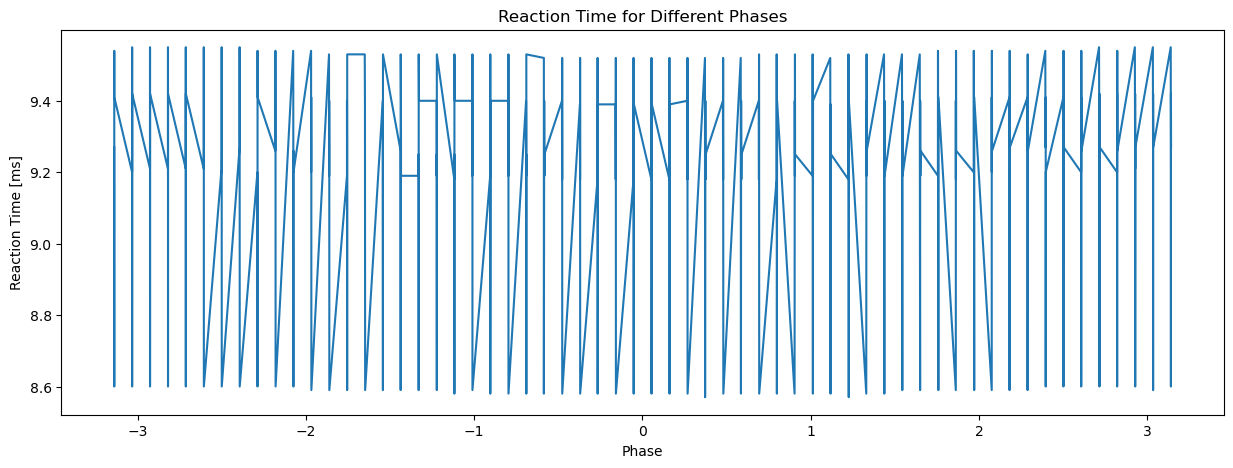

In [10]:
# plot the reaction time for different phases using the csv file in ./data_phase_to_reaction_times
import csv
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

filename = './data_phase_to_reaction_times/reaction_times_241108001631.csv'
filename = './data_phase_to_reaction_times/reaction_times_241108023314.csv'
filename = './data_phase_to_reaction_times/reaction_times_241108045023.csv'
filename = './data_phase_to_reaction_times/reaction_times_241108070650.csv'

phases = []
reaction_times = []

folder_path = './data_phase_to_reaction_times/'
# folder_path = Path('./data_phase_to_reaction_times/')

for file in Path('./data_phase_to_reaction_times/').iterdir():
    print(file.name)
    phases_temp = []
    reaction_times_temp = []
    with open(folder_path+file.name, mode='r') as f:
        reader = csv.reader(f)
        for row in reader:
            phases.append(float(row[0]))
            reaction_times.append(float(row[1]))
            phases_temp.append(float(row[0]))
            reaction_times_temp.append(float(row[1]))
    plt.figure(figsize=(15, 5))
    plt.plot(phases_temp, reaction_times_temp, label=file.name)
    plt.xlabel('Phase')
    plt.ylabel('Reaction Time [ms]')
    plt.title('Reaction Time for Different Phases')
    plt.legend()
    plt.show()

# sort the phases
phases = np.array(phases)
phases_sorted = np.sort(phases)
sort_ind = np.argsort(phases)
reaction_times_sorted = np.array(reaction_times)[sort_ind]


plt.figure(figsize=(15, 5))
# plt.plot(phases, reaction_times)
plt.plot(phases_sorted, reaction_times_sorted)
plt.xlabel('Phase')
plt.ylabel('Reaction Time [ms]')
plt.title('Reaction Time for Different Phases')
plt.show()

